## Classifacation using fixation and saccade duration

In [2]:
from pathlib import Path

import numpy as np

from utils.fixation_saccade import get_sf_df, get_sf_list, plot_sf_list, make_stats, read_all_data, get_all_data

In [3]:
lpr_path = Path("/home/pl/MVA/Medic/data/LCR")
control_path = Path("/home/pl/MVA/Medic/data/Contrôle")

In [4]:
read_kwargs = {"usecols": ["Recording timestamp", "Eye movement type"], "nrows": 10000}

In [6]:
patient_names, patient_sf = read_all_data(lpr_path/"subset", **read_kwargs)
control_names, control_sf = read_all_data(control_path/"subset", **read_kwargs)

Loading dataset /home/pl/MVA/Medic/data/LCR/subset: 100%|██████████| 25/25 [00:24<00:00,  1.04Files/s]
Loading dataset /home/pl/MVA/Medic/data/Contrôle/subset: 100%|██████████| 12/12 [00:11<00:00,  1.01Files/s]


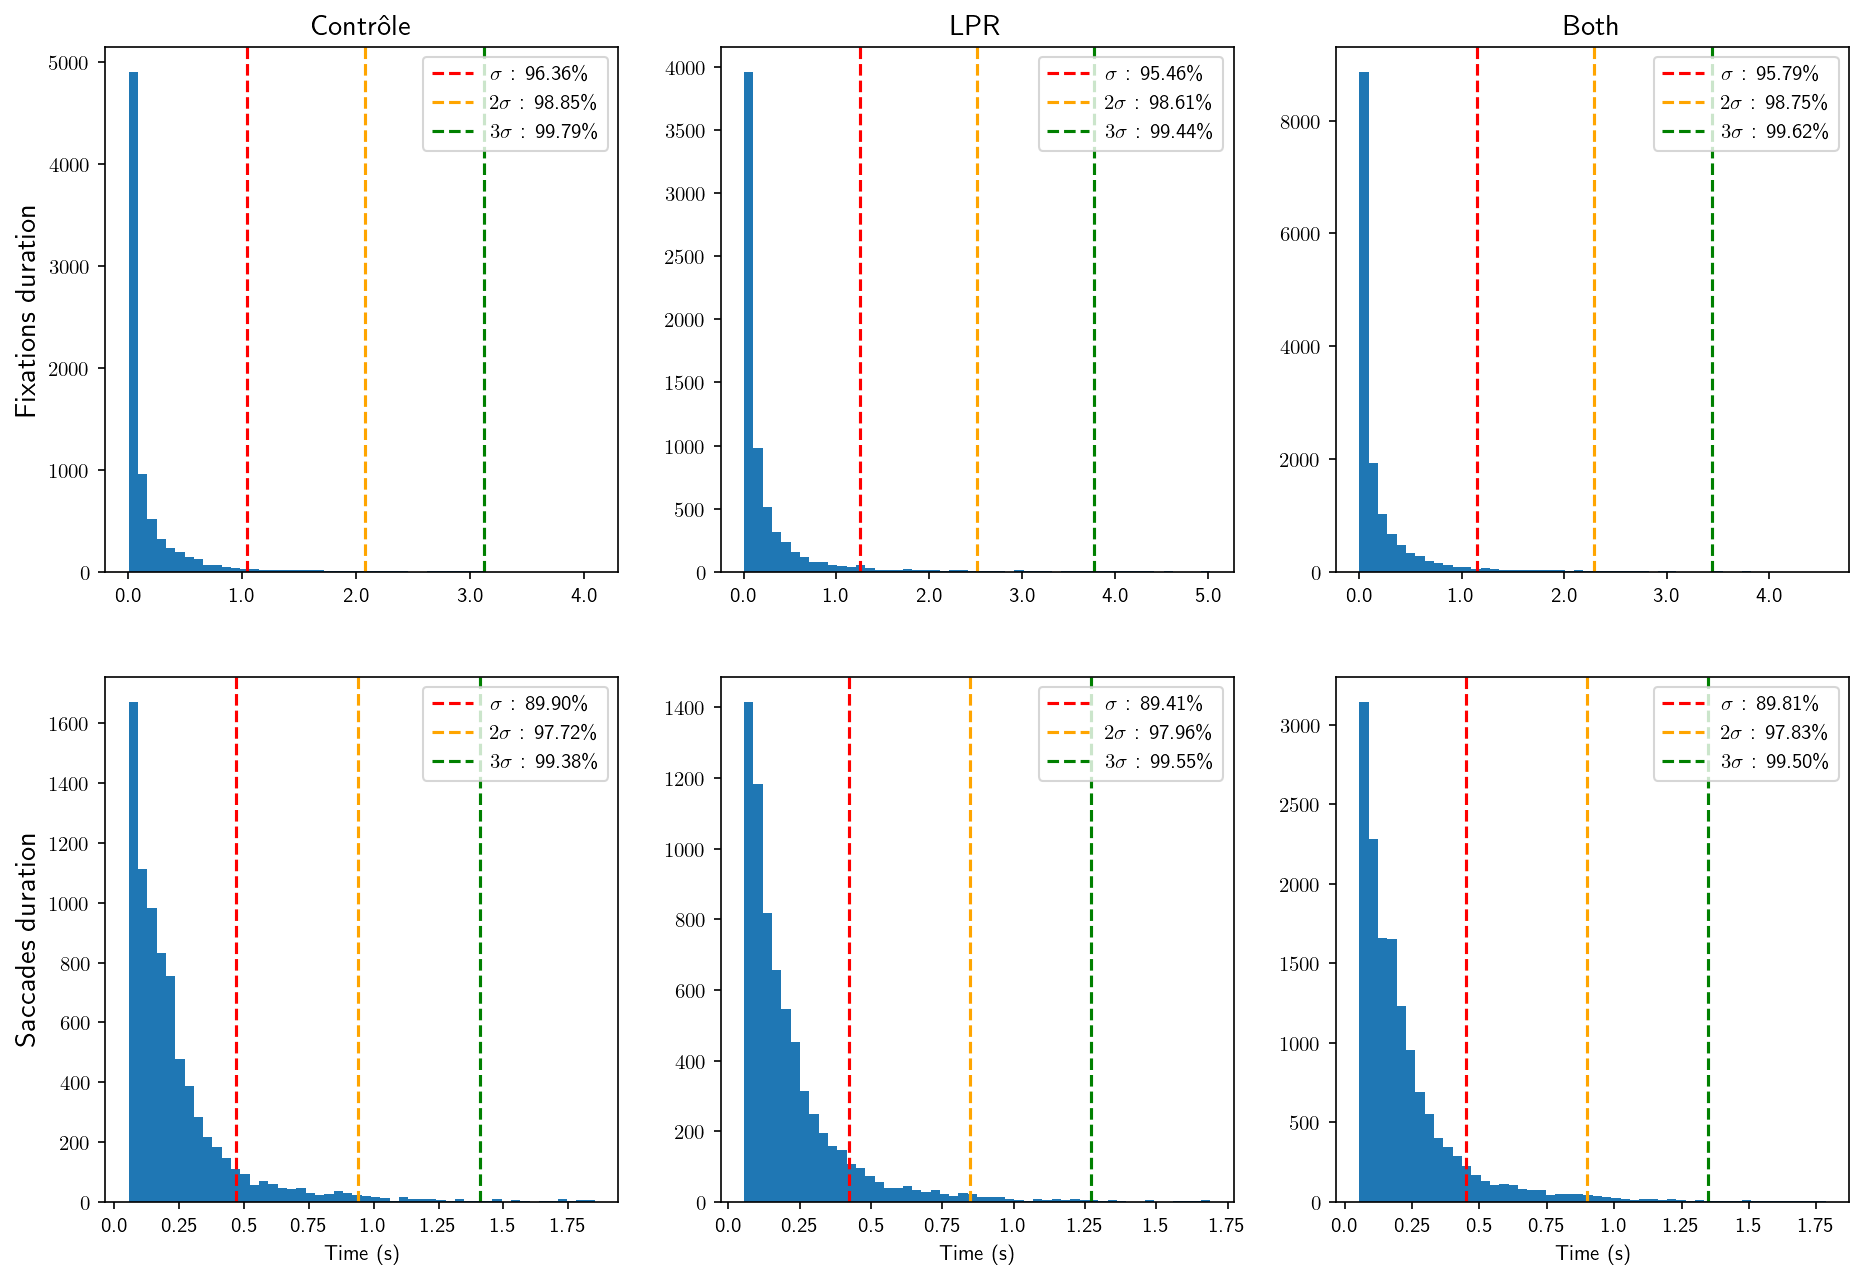

In [39]:
make_stats(patient_sf, control_sf, normalize=False, truncate=True)

### Symbolization

In [9]:
from utils.symbols import Symbols
from utils.fixation_saccade import get_symbols_sequence

In [10]:
alphabet_saccade = ["1","2","3","4"]
alphabet_fixation = ["A","B","C","D"]

In [11]:
data_saccade = get_all_data("Saccade", patient_sf + control_sf)
data_fixation = get_all_data("Fixation", patient_sf + control_sf)

In [12]:
symbols_saccade = Symbols(data_saccade, n_sym=4, alphabet=alphabet_saccade)
symbols_fixation = Symbols(data_fixation, n_sym=4, alphabet=alphabet_fixation)

In [13]:
symbols_saccade.make_symbols()
symbols_fixation.make_symbols()

In [14]:
sequence_symbols = get_symbols_sequence(symbols_saccade.symbolic, symbols_fixation.symbolic,patient_sf+control_sf)

### Use n-grams + Logistic regression to classify

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA

In [56]:
sequence_dataset = sequence_symbols
y = [1] * len(patient_names) + [0]* len(control_names)
y = np.asarray(y).astype(int)

In [29]:
sequence_train, sequence_test, y_train, y_test = train_test_split(sequence_dataset, y,shuffle=True)

In [48]:
# Map sequences to
vec = TfidfVectorizer(analyzer='char', ngram_range=(2, 5))
X_train = vec.fit_transform(sequence_train)
X_test = vec.transform(sequence_test)
X = vec.transform(sequence_dataset)

In [86]:
pca = KernelPCA(n_components=3, kernel="rbf", gamma=10, alpha=0.1)
X_reduced = pca.fit_transform(X.toarray())

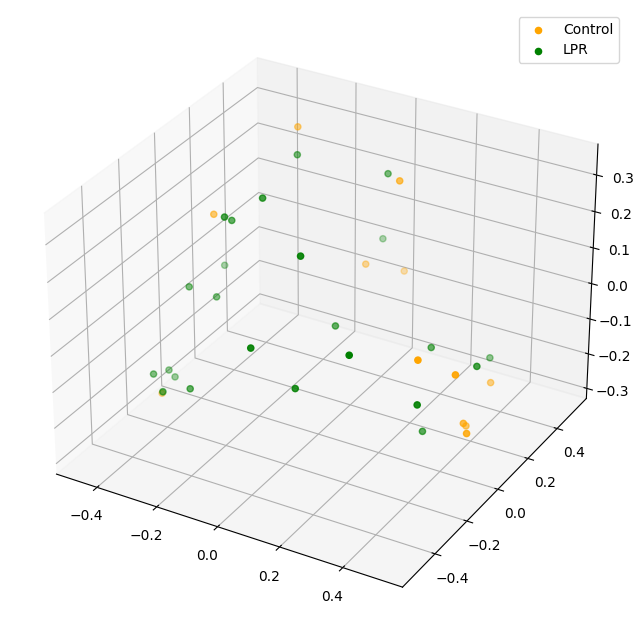

In [87]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection='3d')
label_dict = ["Control","LPR"]
cdict = ['orange','green']
for label in np.unique(y):
    idx = np.where(y==label)
    ax.scatter(X_reduced[idx,0], X_reduced[idx,1], X_reduced[idx,2], c=cdict[label],label=label_dict[label])
ax.legend()
plt.show()

In [43]:
# Train a logistic regression classifier and use the classifier to
# make predictions
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Accuracy score : {accuracy_score(y_pred,y_test)*100:.2f}%")

Accuracy score : 40.00%


In [44]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Accuracy score : {accuracy_score(y_pred,y_test)*100:.2f}%")

Accuracy score : 40.00%
